In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
gen = pd.read_csv('gender.csv', index_col=0)

In [6]:
fem = gen[gen['Gender']==0]
mal = gen[gen['Gender']==1]

In [7]:
def create_survival_df(male_df, female_df, column, interval):
    surv_df = pd.DataFrame(columns = ['male', 'female'])
    for i in np.arange(0,male_df[column].max()+1, interval):
        surv_df.loc[i,'male'] = male_df[male_df[column]>=i].shape[0]/male_df.shape[0]
        surv_df.loc[i,'female'] = female_df[female_df[column]>=i].shape[0]/female_df.shape[0]
    surv_df.reset_index(inplace=True)
    return surv_df

In [8]:
surv_exper_df = create_survival_df(mal, fem, 'Exper', 1)
surv_sal94_df = create_survival_df(mal, fem, 'Sal94', 10000)

Text(0.5, 1.0, 'Survival Curve: Experience in years')

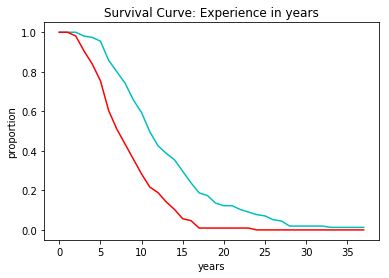

In [9]:
# survival curve: years of experience
fig, ax = plt.subplots()
sns.lineplot(x='index', y='male', data=surv_exper_df, color='c', ax=ax)
sns.lineplot(x='index', y='female', data=surv_exper_df, color='r', ax=ax)
ax.set_xlabel('years')
ax.set_ylabel('proportion')
plt.title('Survival Curve: Experience in years')

In [11]:
'''for each female, find the range of years of experience to find matched males'''
linked_exper = []
for f, frow in fem.iterrows():
    low = frow.Exper*.8
    high = frow.Exper*1.2
    matched_mal = mal[(mal.Exper < high) & (mal.Exper > low)]
    if matched_mal.shape[0]==0:
        continue

    for m, mrow in matched_mal.iterrows():
        linked_exper.append((frow.ID, mrow.ID))
linked_exper_df = pd.DataFrame(linked_exper, columns= ['female_id', 'male_id'])

In [12]:
# sample salary from men matched to women on years of experience only
all_samps_exper = pd.DataFrame()
all_props_exper = pd.DataFrame()
for i in range(0,1000):
    samp_df = linked_exper_df.sample(frac=1).drop_duplicates(subset = 'female_id')
    all_samps_exper.loc[:,i] = gen.loc[samp_df['male_id']].reset_index()['Sal94']
    
# create proportions for survival curve
    for ind in np.arange(0,gen['Sal94'].max()+1, 10000):
        all_props_exper.loc[ind,i] = all_samps_exper[all_samps_exper[i]>=ind].shape[0]/all_samps_exper.shape[0]


In [13]:
# calculate 95% confidence intervals
mins = all_props_exper.quantile(.025, axis=1)
maxes = all_props_exper.quantile(.975, axis=1)

Text(0.5, 1.0, 'Survival Curve: Salary, Matched on years of Experience')

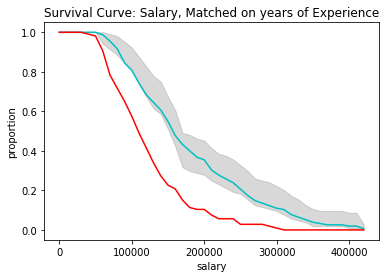

In [14]:
# survival curve
fig, ax = plt.subplots()
sns.lineplot(x='index', y='male', data=surv_sal94_df, color='c', ax=ax)
sns.lineplot(x='index', y='female', data=surv_sal94_df, color='r', ax=ax)
plt.fill_between(x=all_props_exper.index.values, y1=mins, y2=maxes, alpha=.3, color='gray')
ax.set_xlabel('salary')
ax.set_ylabel('proportion')
plt.title('Survival Curve: Salary, Matched on years of Experience')